Daniel Pflueger, 2021-29-11, d.pfluger@uu.nl

In [1]:
import expected_fields as xf
import xarray as xr
import matplotlib.pyplot as plt

# Pre-processing of data

In a first step, we must obtain the fields out of which we create expected fields for later scaling. Usually we look at the difference field $\Delta F$ between a control and a geoengineering run, i.e. $\Delta F = F_{\mathrm{geo}} - F_{\mathrm{cnt}}$ where  $F_{\mathrm{geo}}$ and $F_{\mathrm{cnt}}$ are the field values in the geoengineering and control run respectively.

To have `xarray` compute a sensible difference between the two fields, we must ensure that they have the same time axis. There are two options to do this:
* Resample both fields/datasets to a common time axis (e.g. daily)
* Interpolate one of the fields/datasets to the time axis of the other

Both approaches are convenient to implement in `xarray` but the first might take up a lot of space because of the daily interpolation. I will therefore interpolate to the time axis of the geoengineering run.

In [2]:
# Loading data 
# ! Edit the paths to your file paths !
path_cnt = "../27_05_21/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_c190529.nc"
path_geo = "../27_05_21/ozone_strataero_WACCM_L70_zm5day_2020-2100_SSP585cmip6.feedback.15C.003_c20210131.nc"

# Chunking/dask enabled for better performance
ds_geo_total = xr.open_dataset(path_geo,chunks={'lat':-1, 'lev':-1, 'time': 400})
ds_cnt_total = xr.open_dataset(path_cnt,chunks={'lat':-1, 'lev':-1, 'time': 400})

# Constrain data to 2020 to 2100 because there is a discontinuity afterwards
time_sel = slice('2020','2100')
ds_geo = ds_geo_total.sel(time=time_sel)
ds_cnt = ds_cnt_total.sel(time=time_sel)

# Removing irrelevant data to speed up the interpolation
ds_cnt = ds_cnt.drop_vars(['icenuc_num','NITROP_PD'])

# Interpolate the ds_cnt dataset onto the ds_geo time coordinates
# This operation will be applied to all fields in ds_cnt
ds_cnt = ds_cnt.interp(time=ds_geo.time)

# check that both time axis are equal
# the following line should produce a horizontal line with value 1
# (ds_cnt.time == ds_geo.time).plot() 

# this takes the difference over _all_ variables in the datasets
# including the ones we don't want to modify! I will restore these manually...
ds_diff = (ds_geo - ds_cnt)
# restore auxilliary variables
aux = ['hyai','hybi','hyam','hybm','PS','P0']
for var_name in aux:
    ds_diff[var_name].data = ds_geo[var_name].data

# Building an expected field

To build an expected field, we need only four things:
* The dataset of the difference data
* The name of the field we want to create an expected field for
* Time boundaries $t_i$, $t_f$ such that the averaging is done for years $t$: $t_i<t<t_f$
* The normalizing function we want to use, e.g. `xf.int_mass` for the `so4mass_a3` field

These are the arguments used in `xf.build_expected_field`. The output of the function is a dictionary with the keywords
* `"exp_field"`: a DataArray with dayofyear time coordinates describing the expected field
* `"n"`: the annual normalization constants as DataArray with integer year time coordinates
* `"nday"`: the daily normalization constants of the original field with original time coordinates

In the following examples, I will use 2070-2100 as the averaging period.

## Mass field

Use `xf.int_mass` as normalization function. 

Note that when you are using a difference dataset, you can not uniquely determine the pressure levels so there is still some degree of arbitrariness to the result.

In [3]:
#%%timeit
#->2.2 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
res_mass = xf.build_expected_field(ds_diff,'so4mass_a3',[2070,2100],
                                  norm=xf.int_mass)

Text(0, 0.5, 'Aerosol mass a3 mode [Tg SO4]')

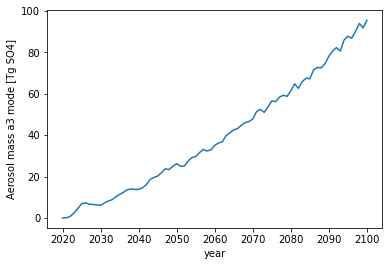

In [4]:
(res_mass['n']/10**9).plot()
plt.ylabel('Aerosol mass a3 mode [Tg SO4]')

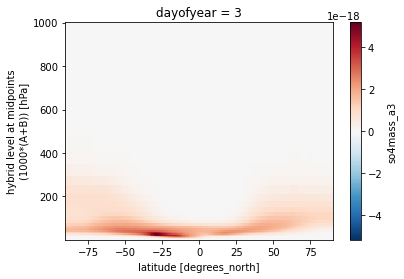

In [5]:
res_mass['exp_field'].isel(dayofyear=0).plot()

## AOD field

Use `xf.int_aod`.

In [6]:
#%%timeit
#->532 ms ± 48.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
res_aod = xf.build_expected_field(ds_diff,'AODVISstdn',[2070,2100],
                                  norm=xf.int_aod)

Text(0, 0.5, 'Global mean AODVISstdn [dim.less]')

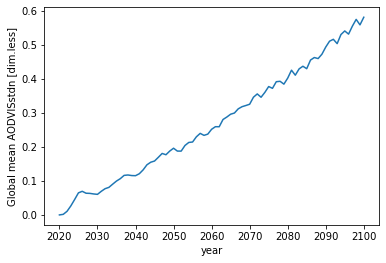

In [7]:
res_aod['n'].plot()
plt.ylabel('Global mean AODVISstdn [dim.less]')

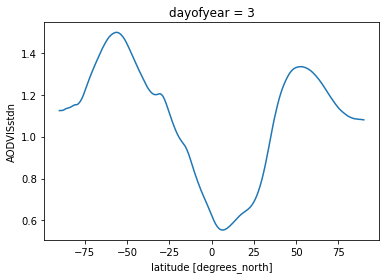

In [8]:
res_aod['exp_field'].isel(dayofyear=0).plot()

## Other fields (general integration rule)

For a general field with lev/lat dimensions, the function `xf.int_l2_lev` can be used as a normalizer. It is the default `norm` argument of `xf.build_expected_field`. Here I use the field `diamwet_a3` as an example.

In [9]:
#%%timeit
#->544 ms ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
res_general = xf.build_expected_field(ds_diff,'diamwet_a3',[2070,2100])

Text(0, 0.5, 'Norm of diamwet_a3 [a.u.]')

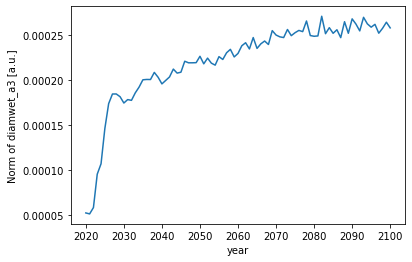

In [10]:
res_general['n'].plot()
plt.ylabel('Norm of diamwet_a3 [a.u.]')

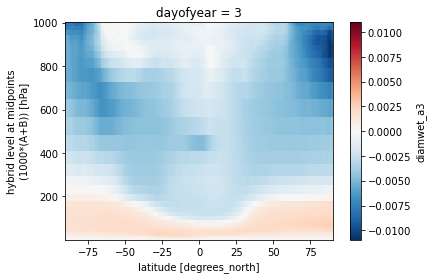

In [11]:
res_general['exp_field'].isel(dayofyear=0).plot()

# Workflow: Creating, loading and saving data

I have implemented the routines `xf.save_exp` and `xf.load_exp` to store expected field and normalization constant data. To test them, I will generate multiple results for the fields `so4mass_a3`, `diamwet_a3` and `SAD_AERO` and thereby present a short and concise workflow for generating expected fields.

1. Define field names and normalization schemes for the respective fields

In [12]:
# Define the fields you want to consider along with their normalization scheme
# Fields for which to compute the expected fields with their respective normalizers
fields = {
    'so4mass_a3': xf.int_mass,
    'diamwet_a3': xf.int_l2_lev,
    'SAD_AERO': xf.int_l2_barometric, # xf.int_l2_lev yields sub-optimal results for SAD_AERO
}
tbounds = [2070,2099]

results = {}
for field,norm in fields.items():
    print(field)
    results[field] = xf.build_expected_field(ds_diff,field,tbounds,norm=norm)

so4mass_a3
diamwet_a3
SAD_AERO


2. Save the expected fields and normalization constants

In [13]:
save_path = './exp_fields_examples/'
for field,res_dict in results.items():
    xf.save_exp(res_dict,save_path)

Data directory ./exp_fields_examples/so4mass_a3/ found. Possibly overwriting data.
Data directory ./exp_fields_examples/diamwet_a3/ found. Possibly overwriting data.
Data directory ./exp_fields_examples/SAD_AERO/ found. Possibly overwriting data.


3. Load the fields

In [14]:
results = xf.load_exp('./exp_fields_examples/')

You can see all results in the `results` dictionary using the original field names as keywords. Then, the `n`, `nday` and `exp_field` keywords give you the computed data.

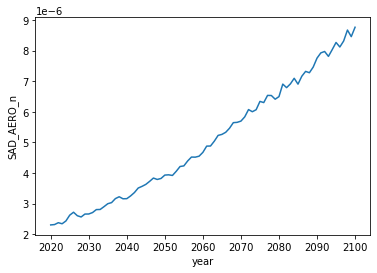

In [15]:
results['SAD_AERO']['n'].plot()

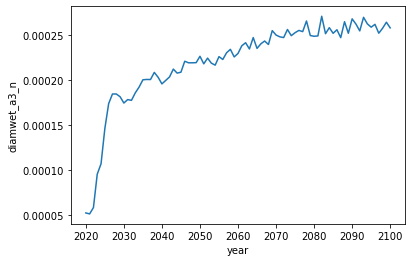

In [16]:
results['diamwet_a3']['n'].plot()

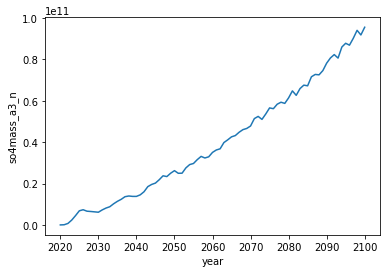

In [17]:
results['so4mass_a3']['n'].plot()